# Proximal Policy Optimization (PPO)


https://arxiv.org/pdf/1707.06347.pdf

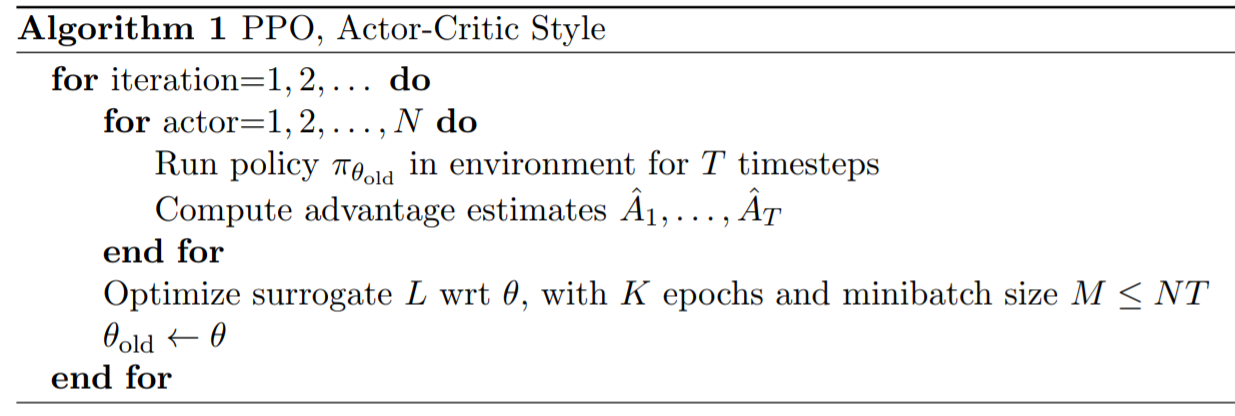

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
epochs_number = 50000
batch_size = 256
replay_buffer_size = batch_size
l2_regularization = 0
clip_ratio = 0.2

policy_updates_on_batch = 40
value_updates_on_batch = 40

discount_factor = 0.98
lambda_factor = 0.96

env_name = 'LunarLander-v2'
environments_count = 40

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.relu)
        l2 = tf.layers.dense(self.state_ph, units=50, activation=tf.nn.relu)

        output_linear = tf.layers.dense(l2, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        
        # Training
        output_log = tf.nn.log_softmax(output_linear)
        self.log_pi = tf.reduce_max(output_log, axis=-1)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)
        self.log_pi_old_ph = tf.placeholder(shape=[None], dtype=tf.float32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        
        
        # PPO update part
        ratio = tf.exp(self.log_pi - self.log_pi_old_ph)          # pi(a|s) / pi_old(a|s)
        min_adv = tf.where(self.weight_ph > 0, (1 + clip_ratio) * self.weight_ph, (1 - clip_ratio) * self.weight_ph)
        self.loss = -tf.reduce_mean(tf.minimum(ratio * self.weight_ph, min_adv))
        
        self.update_op = tf.train.AdamOptimizer(actor_learning_rate).minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)

actor = ActorNetworkDiscrete()
critic = CriticNetwork()

W0721 21:29:14.780059  1456 deprecation.py:323] From <ipython-input-4-1ae7c1409743>:34: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0721 21:29:14.784012  1456 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0721 21:29:15.049931  1456 deprecation.py:323] From <ipython-input-4-1ae7c1409743>:40: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.
W0721 21:29:15.061897  1456 deprecation.py:323] From <ipython-input-4-1ae7c1409743>:58: add_dispatch_support.<locals>

Tensor("Squeeze_1:0", shape=(?,), dtype=float32)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [6]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [7]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

### Advantage estimation formulas

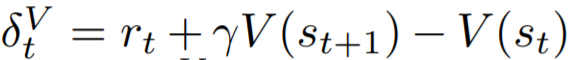

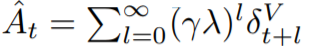

In [8]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [9]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, log_pi, discounted reward-to-go]
    replay_buffer = np.empty((0, 5), np.float32)
    
    # [state, action, reward, log_pi] rollout lists for every environment instance
    rollouts = [np.empty((0, 4)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions, log_pi = sess.run([actor.action_op, actor.log_pi], feed_dict={actor.state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards, log_pi)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage
                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)
                
                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 4))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([-0.03263082,  1.3791988 , -0.35713625, -0.25277698,  0.03805212,
        0.06023437,  0.        ,  0.        ], dtype=float32),
        0, -16.271491783208628, -1.2752808, -56.806901202377894],
       [array([-0.2417007 ,  0.6850051 , -0.52651155, -1.0096955 ,  0.3788108 ,
        0.12431936,  0.        ,  0.        ], dtype=float32),
        1, -38.05430490883576, -1.0176172, -77.61135820276296],
       [array([-0.08241911,  0.9786717 , -0.30903322, -0.81947494,  0.10707736,
        0.2167666 ,  0.        ,  0.        ], dtype=float32),
        0, -11.64593368952622, -1.1706145, -46.64790940306136],
       [array([ 0.41610345, -0.00591401,  0.47328037, -1.4494956 ,  0.24017152,
        0.14938042,  0.        ,  0.        ], dtype=float32),
        2, -85.01528203756808, -1.1314082, -88.84250926971436],
       [array([-0.09068413,  1.2614756 , -0.36430445, -0.48035458,  0.14125542,
        0.1217152 ,  0.        ,  0.        ], dtype=float32),
        2, -17.580761571701

## Train agent 

In [10]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [44]:
from tqdm import tqdm_notebook
import pickle

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

saver = tf.train.Saver()


# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

max_value = 114
actor_loss = 0

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value
        
        with open(f'models/{env_name}-reward({value}).history', 'wb') as f:
            pickle.dump(history, f)

    # Train actor on minibatch
    for i in range(policy_updates_on_batch):
        _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                                    actor.state_ph: np.array(batch[:, 0].tolist()),
                                                    actor.action_ph: np.array(batch[:, 1].tolist()),
                                                    actor.weight_ph: batch[:, 2],
                                                    actor.log_pi_old_ph: batch[:, 3]})
        if i == 0:
            history['actor_loss'].append(actor_loss)

    for i in range(value_updates_on_batch):
        _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                                    critic.state_ph: np.array(batch[:, 0].tolist()),
                                                    critic.value_ph: batch[:, 4]})
        if i == 0:
            history['critic_loss'].append(critic_loss)

#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    



Charging generators


Model saved in path: ./models/LunarLander-v2-reward-120.ckpt


KeyboardInterrupt: 

Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'LunarLander-v2')

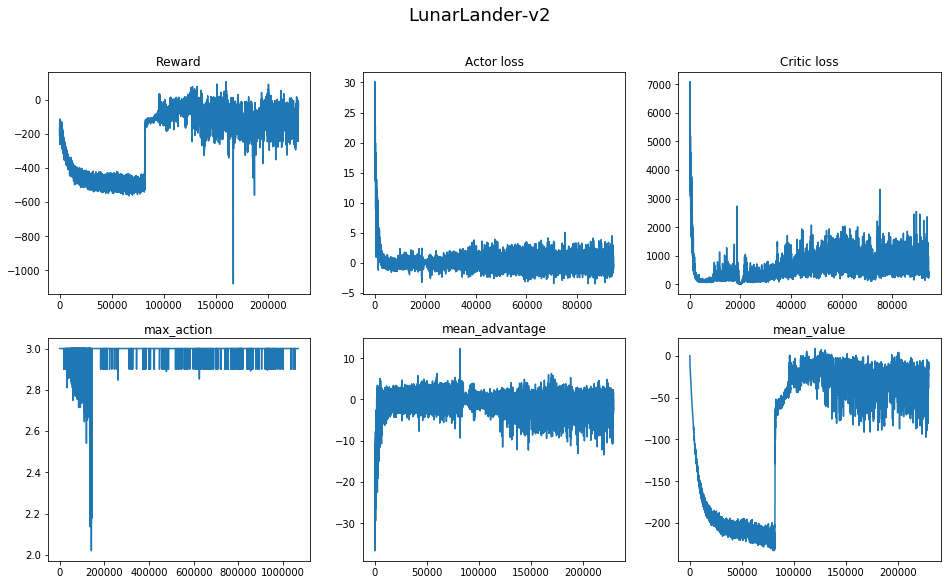

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

#plt.savefig(f'logs/{env_name}')

## Our agent

In [47]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})
    
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])

    print('h', rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


h -1.0242186778133942 0
h -1.2048585417379059 0
h -0.27665013904845526 3
h 2.013684151162079 2
h -0.2641680014636154 3
h -0.11554261215127212 3
h 2.447313350014139 2
h 2.4679973363203205 2
h 2.0864221315035367 2
h -0.9221432168769184 0
h 0.3458377363167074 2
h -0.9379029399785566 0
h 3.3993142870817623 2
h 0.12588032477128877 3
h -2.0063369839536436 1
h 3.4014911107458206 2
h 0.8211126487910974 2
h 0.48169698163804925 2
h -2.2042673631532623 1
h -0.33419821338327327 3
h 0.8771846037074738 2
h -0.13270113934913638 3
h 0.9795016115061628 2
h -1.3176980530512878 0
h -1.4674000609709026 0
h -2.040184089186566 1
h 0.4457290938853305 2
h -0.8345036154424463 2
h 1.2330142659906584 2
h 2.739578665767749 2
h 3.382406425193449 2
h 0.45407431841352947 2
h -1.0063071621295876 0
h -1.8075179330535025 1
h 1.8836606809151248 2
h 0.1759940776237386 2
h 1.254315381880258 2
h -0.15843189397511878 3
h 1.4614618653303466 2
h -1.7726084568583633 1
h 1.573591457372271 2
h -0.22179206907304547 3
h 1.28679959

h 2.863874384538474 2
h -2.193615219604679 3
h -2.425331654705387 1
h -2.6678043111508303 1
h -2.4614987021979857 0
h -2.216827734359525 3
h -1.9217232770170927 3
h 3.2642166244909108 2
h 1.4935710263558917 2
h -2.321155841193898 1
h 0.6927081744668555 2
h 1.5263237584087619 2
h -2.108986585458524 0
h 1.1916997169522403 2
h 3.2495144346597273 2
h -2.181455318990288 0
h 1.0228015774391792 2
h 1.2029994307336096 2
h 1.6722312309690437 2
h -2.232560594778107 0
h -1.7615172619043153 3
h 1.4683732786812527 2
h 2.947950888277501 2
h -1.2968642575322054 3
h 4.2298271144718855 2
h 3.0957689108559636 2
h -1.355975670043988 3
h -1.6968428045807116 0
h 2.755194986356895 2
h 4.133721403891255 2
h 2.362955938188162 2
h -2.3230762163489787 1
h -1.0142334776703013 3
h -1.6282440044903126 0
h 0.39600286540199364 2
h -1.616031653857192 0
h 0.5553765031279283 2
h 3.674764895324171 2
h 2.276864692900756 2
h -1.2606822013554222 0
h -0.6407377090711879 3
h 2.9996639433008 2
h 2.5924598508102834 2
h 1.99230

h -1.2790425800705976 2
h 1.0587181705938928 3
h -0.8609434960678743 1
h -1.4242072675032194 1
h -1.2925451424730727 1
h 0.7344167386049218 3
h 0.7539307360390921 2
h -0.3286020075169631 0
h -1.3488145049001037 1
h 0.6811099181615361 2
h 1.0734672925909308 2
h 0.4593362421466918 3
h 0.5715230898588401 2
h 0.8295996092268012 2
h -1.2604901487886184 1
h -0.2371001782882331 2
h 0.007857401854562351 2
h -0.330773142904917 0
h 0.5320350967892693 2
h 2.801192924960117 2
h 0.6769573777739708 2
h -0.4455592753062092 0
h -0.08699563570145868 2
h 0.9737225639956091 3
h -1.253877729748125 1
h 2.3137614495478944 2
h 1.7608302508703815 2
h 0.5431376715783796 3
h -1.5632661886680939 1
h -1.7318979186046153 1
h 1.4832797219681992 2
h -2.0909816567765476 1
h -0.98902314202887 0
h 0.23166880394132933 2
h -1.0254139777638898 0
h -0.39899930175598114 2
h 0.9981351011090396 2
h 0.0347393603990554 2
h -2.1049918545168667 1
h -0.4030423138226513 3
h -0.013357010740974146 3
h 0.5022739611083409 2
h -0.625461

h -1.4630089312250323 1
h 0.8168480349130516 3
h -0.05172958834826885 2
h 3.1364467663266398 2
h 0.8174991759333079 3
h 1.3232339315174613 2
h 0.9566520311035174 3
h 1.0445281015436307 2
h 2.3617369192044295 2
h -0.8519276573667287 1
h -0.23274493521883527 2
h -0.616573190515253 3
h 1.1987640439779852 2
h 0.9997886785650507 2
h 0.2499194235708842 2
h 2.396652902475421 2
h -1.2635560837268258 0
h -1.2821646845661974 0
h 1.5635195388376644 2
h 0.14400976931024162 2
h 1.0909947137200333 2
h 3.14502383763043 2
h -2.0217873709729575 1
h 1.96041138244463 2
h 1.9705063207047828 2
h -1.0099292957713146 0
h 0.5003377439444818 2
h 2.418773301900285 2
h 1.075722506223667 2
h 1.2108659453812833 2
h 1.1715407160388736 2
h -0.9776449047547544 0
h -0.22929911758111984 3
h -0.9164371422739237 2
h 0.4125385136957334 2
h 1.4336034809927127 2
h -0.2938459425916335 2
h -0.9313321143673818 2
h -0.6551808054292667 3
h -0.3721893121801145 2
h 0.53483145482694 2
h -1.6694654782502312 0
h -1.7139721908796446 0

h 1.5552302142799885 1
h 1.0787446355142094 2
h 0.8098446829882391 2
h 1.7720143193589604 1
h -1.0870865078295993 2
h 1.8625880401959887 1
h -1.1362452881926572 2
h -0.08856539469035168 2
h -0.17535630475468905 2
h -0.7909987929041506 2
h 1.6659787548717702 2
h 1.3169228674704812 0
h 1.2343402168299065 0
h 1.4672673133619127 2
h -0.027989729159030502 3
h 0.9133780391012749 0
h -0.48458814583221854 3
h 0.5483919310659644 0
h 0.476674139421732 0
h -0.6110280550167306 3
h 1.228570898401075 1
h -0.6853552036361055 1
h -1.5927289315886526 0
h -1.6410817758982148 0
h -1.0078659361005566 1
h 1.2810437569053874 2
h -2.6045713427304507 3
h -1.0504476659035606 1
h 1.6951055719965609 2
h -1.9543600890151538 0
h -1.5533068168917044 1
h 0.02667499735174489 2
h 0.6829310741864674 2
h -2.7036627478328783 3
h -2.6291616773901 3
h 1.8510840876095187 2
h -2.3973783710197254 3
h -1.8194726479689791 0
h 1.8536662460101183 2
h 1.3942069776141295 2
h 2.1723896400614366 2
h -1.8887183892503572 0
h -0.3410224

h 12.4132201192471 0
h -0.21471156154872517 0
h -0.7143421734815547 0
h -0.7112670629821309 0
h -0.7053100622080422 0
h 11.596536281531613 0
h 1.0083100146332953 0
h -0.01638520147628128 3
h -0.15550927000343506 0
h 0.1412502825310895 0
h 0.10483106743569692 0
h -0.2584779319356858 3
h 0.07198421628052756 3
h -0.07484379072084835 0
h 0.07096573973959153 0
h 0.11818785223526618 0
h -0.0006979668357729452 0
h 0.008411838776979152 0
h -0.2361157528670634 3
h 0.07415452046573989 0
h 0.05278861608819341 0
h -0.1125135135586379 3
h 0.07275101425470609 0
h 0.03001196799546335 0
h -0.13355202920240458 3
h 0.06950510105363605 0
h 0.03238413620803726 0
h 0.06356645517681159 0
h -0.00393608389886424 0
h 0.00539855094406505 0
h 0.005090673623755038 0
h -5.106174646615147 2
h -19.97353655763102 3
h 13.013398903133691 0
h 0.6587509380287611 1
h -2.2046380220972837 1
h 9.90717546612993 1
h 3.1380226860421643 3
h -0.912567613993619 2
h -2.136745886046003 2
h -20.432864849488396 3
h 12.17400386661271 1

KeyboardInterrupt: 

## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/LunarLanderContinuous-v2-reward-96.ckpt")

In [ ]:
d = 20
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], d)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], d)
q_table = np.zeros((d, d))

for i in range(len(x)):
    for j in range(len(y)):
        q_table[i][j] = sess.run(critic.value_op, feed_dict={critic.state_ph: [[x[i], y[j]]]})[0]


In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = q_table


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)